In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
df = pd.read_csv("bank-additional-full.csv", sep = ";")

In [5]:
df1 = pd.get_dummies(df, df.columns[df.dtypes == 'object'])

In [11]:
df_train, df_test = train_test_split(df1, train_size = 0.8, random_state = 42)


In [12]:
x_train = df_train.drop(['y_yes', 'y_no'], axis=1)
x_test = df_test.drop(['y_yes', 'y_no'], axis=1)
y_train = df_train['y_yes']
y_test = df_test['y_yes']

In [13]:
# Train model using hyperparmeter tuning
def training_model_hyperparameter(model, scoring, params_grid, x_train, y_train):
    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)

    grid = GridSearchCV(estimator = model, scoring=scoring, param_grid = params_grid, cv = folds, 
                           verbose=0, return_train_score=True, n_jobs=3)
    grid.fit(x_train, y_train)
    return grid

In [14]:
# Predict values and propability of training and testing data
def prediction_model(model, x_train, y_train, x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_train_pred_prob = model.predict_proba(x_train)[:, 1]
    y_test_pred = model.predict(x_test)
    y_test_pred_prob = model.predict_proba(x_test)[:, 1]
    return y_train_pred, y_train_pred_prob, y_test_pred, y_test_pred_prob

In [15]:
# Draw ROC curve from training and test data probability
def draw_roc( train_actual, train_probs, test_actual, test_probs ):
    train_fpr, train_tpr, train_thresholds = metrics.roc_curve( train_actual, train_probs,
                                              drop_intermediate = False )
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve( test_actual, test_probs,
                                              drop_intermediate = False )
    train_auc_score = metrics.roc_auc_score( train_actual, train_probs )
    test_auc_score = metrics.roc_auc_score( test_actual, test_probs )
    plt.figure(figsize=(5, 5))
    plt.plot( train_fpr, train_tpr, label='ROC curve (area = %0.2f)' % train_auc_score )
    plt.plot( test_fpr, test_tpr, label='ROC curve (area = %0.2f)' % test_auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [16]:
from xgboost import XGBClassifier

In [17]:
clf = xgb.XGBClassifier()

In [31]:
clf.fit(X=x_train, y=y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
param_grid_xgb = {'max_depth': [5,7],
                  'max_features': [10, 20, 30]}

In [19]:
clf_grid = training_model_hyperparameter(clf, 'roc_auc', param_grid_xgb, x_train, y_train) 

[20:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



In [20]:
y_train_pred_xgb, y_train_pred_xgb_prob, y_test_pred_xgb, y_test_pred_xgb_prob = prediction_model(clf_grid, x_train, y_train, x_test, y_test)

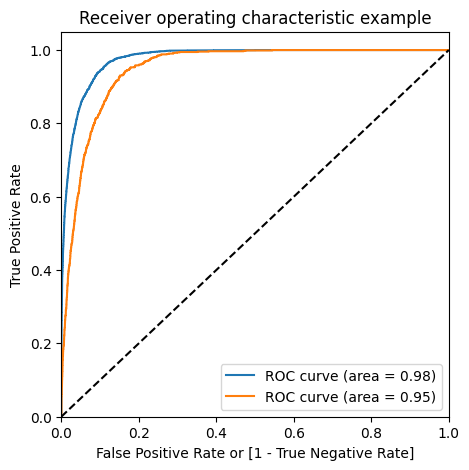

In [21]:
draw_roc(y_train, y_train_pred_xgb_prob, y_test, y_test_pred_xgb_prob)

In [32]:
import joblib
filename = 'DEMO-local-xgboost-model'
joblib.dump(clf, filename)

['xgb_model']

In [23]:
print(xgb.__version__)

1.7.6


In [28]:
test = df_train.drop(['y_yes', 'y_no'], axis=1).head()

In [29]:
test.to_csv('test.csv', header=False, index=False)